# **Tutorial 5 - Class Activation Map (CAM) Visualization**

## 1. What is CAM?

Class Activation Map (CAM) is a weighted activation map generated for each image. It helps to identify the **region** a CNN is looking at while classifying an image. For example:

<p align="center">
<img height="250" src='https://i.imgur.com/DevTfek.png' />
</p>

We will focus on **the last convolution layer**, right before the classification layer (softmax). Each feature map of the last convolutional layer focuses on detecting one concept. For example, the feature map 1 in the network below might detect human faces, whereas feature map 2 is responsible for detecting the fur of a dog and feature map k is responsible for detecting the ears of a dog. The combination of several concepts then forms an object.

<p align="center">
<img src='https://johfischer.com/wp-content/uploads/2022/01/slide2-1-768x341.png' />
</p>

By projecting the output layer weights back into the feature maps derived from the last convolution layer, the **importance** of the image regions is identifiable. To obtain the CAM for a particular class (or category), we compute the linear combination of the weights of corresponding class and feature maps. For example, we get the CAM for class 2 by the following expression:

<p align="center">
<img src='https://johfischer.com/wp-content/uploads/2022/01/slide7-1-768x282.png' />
</p>

More readings:
- https://johfischer.com/2022/01/27/class-activation-maps/
- https://towardsdatascience.com/class-activation-mapping-using-transfer-learning-of-resnet50-e8ca7cfd657e

## 2. CAM comparison between different models

We will compare the CAM on some images of the following models: ResNet18, ResNet50, EfficientNetB0, DenseNet101; with the pre-trained weights on the ImageNet dataset.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms
from torchsummary import summary
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SIZE = 224

In [ ]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
def compute_CAM(feature_conv, weight_softmax, class_idx, size=SIZE):
  # we will generate the class activation maps upsample to size x size
  size_upsample = (size, size)

  batch_size, num_channels, h, w = feature_conv.shape
  output_cam = []
  for idx in class_idx:
      cam = weight_softmax[idx].dot(feature_conv.reshape((num_channels, h * w)))
      cam = cam.reshape(h, w)
      cam = cam - np.min(cam)
      cam_img = cam / np.max(cam)
      cam_img = np.uint8(255 * cam_img)
      output_cam.append(cv2.resize(cam_img, size_upsample))

  return output_cam

def overlay_CAM(pil_img, cam, size=SIZE):
  img = pil_img.resize((size, size))
  img_np = np.array(img)
  heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  result = heatmap * 0.5 + img_np * 0.5
  return result / 255.0

### 2.1. Define the models

Firstly, we define the base class for models:

In [ ]:
class BaseModel(nn.Module):
  def __init__(self):
    super(BaseModel, self).__init__()
    self.conv = None
    self.fc = None
    
  def get_CAM(self, img):
    # img: PIL Image
    # this method returns the CAM of an image (for predicted class)
    
    # weight of output layer
    params = list(self.fc.parameters())
    weight = np.squeeze(params[0].data.cpu().detach().numpy())

    t_img = transform(img).unsqueeze(0)
    t_img = t_img.to(device)

    # predicted class
    with torch.no_grad():
      logit = self.forward(t_img)
    probs = F.softmax(logit, dim=1).data.squeeze()
    class_idx = torch.argmax(probs).cpu().detach().numpy()

    # feature maps
    feature_maps = self.conv(t_img)

    return compute_CAM(feature_maps.cpu().detach().numpy(), weight, [class_idx])[0]

ResNet:

- Let's take a look at the architecture of ResNet18. It has 3 main components: features (from `conv1` to `layer4`), `avgpool`, `fc`.

In [ ]:
models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


- We will use the output of last layer in components features as the feature maps of the last convolution layer. For the output weights, it will be the weight of `fc`.

- **Note.** The similar steps will be applied for other models as well.

In [ ]:
class ResNet(BaseModel):
  def __init__(self, version='resnet18'):
    super(ResNet, self).__init__()

    if version == 'resnet18':
      base = models.resnet18(weights='IMAGENET1K_V1')
    elif version == 'resnet50':
      base = models.resnet50(weights='IMAGENET1K_V1')
    else:
      print('Wrong value for version!')
      return

    self.conv = nn.Sequential(
        *list(base.children())[:-2]
    )

    self.avgpool = base.avgpool
    self.fc = base.fc
    
  def forward(self, x):
    x = self.conv(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

EfficientNet:

In [ ]:
class EfficientNet(BaseModel):
  def __init__(self, version='efficientnet_b0'):
    super(EfficientNet, self).__init__()

    if version == 'efficientnet_b0':
      base = models.efficientnet_b0(weights='IMAGENET1K_V1')
    elif version == 'efficientnet_b1':
      base = models.efficientnet_b1(weights='IMAGENET1K_V1')
    else:
      print('Wrong value for version!')
      return

    self.conv = nn.Sequential(
        *list(base.children())[:-2]
    )

    self.avgpool = base.avgpool
    self.fc = base.classifier
    
  def forward(self, x):
    x = self.conv(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

DenseNet:

In [ ]:
class DenseNet(BaseModel):
  def __init__(self, version='densenet121'):
    super(DenseNet, self).__init__()

    if version == 'densenet121':
      base = models.densenet121(weights='IMAGENET1K_V1')
    elif version == 'densenet169':
      base = models.densenet169(weights='IMAGENET1K_V1')
    else:
      print('Wrong value for version!')
      return

    self.conv = base.features
    self.fc = base.classifier
    
  def forward(self, x):
    x = self.conv(x)
    x = F.relu(x, inplace=True)
    x = F.adaptive_avg_pool2d(x, (1, 1))
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

### 2.2. Visualization

We will compare the CAM of models on 4 images:

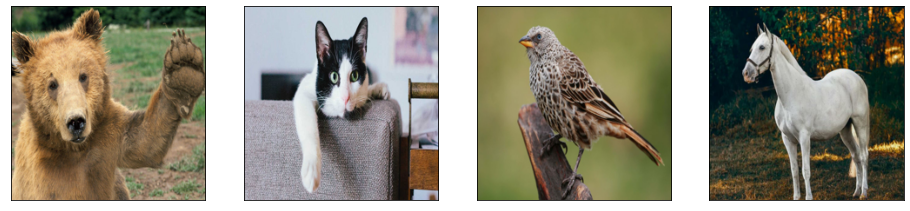

In [ ]:
paths = ['bear.jpg', 'cat.jpg', 'bird.jpg', 'horse.jpg']
plt.figure(figsize=(16, 8))
for i, path in enumerate(paths):
  plt.subplot(1, 4, i + 1)
  img = Image.open(path)
  img = img.resize((SIZE, SIZE))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

In [ ]:
resnet18 = ResNet(version='resnet18')
resnet18 = resnet18.to(device)

resnet50 = ResNet(version='resnet50')
resnet50 = resnet50.to(device)

effi_b0 = EfficientNet(version='efficientnet_b0')
effi_b0 = effi_b0.to(device)

densenet121 = DenseNet(version='densenet121')
densenet121 = densenet121.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
my_models = {
    'ResNet18': resnet18,
    'ResNet50': resnet50,
    'EfficientNetB0': effi_b0,
    'DenseNet121': densenet121
}

CAM_images = {
    'ResNet18': {},
    'ResNet50': {},
    'EfficientNetB0': {},
    'DenseNet121': {}
}

In [ ]:
def compare_CAM(img_paths):
  rows = len(img_paths)
  cols = len(my_models.keys()) + 1

  fig, ax = plt.subplots(rows, cols, figsize=(16, 16))
  fig.suptitle('Compare CAM between models', fontsize=24)

  for row, path in enumerate(img_paths):
    img = Image.open(path)
    img = img.resize((SIZE, SIZE))
    col = 0

    i, j = row, col
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].set_title('Original Image')
    ax[i][j].imshow(img)

    for name, model in my_models.items():
      col += 1
      i, j = row, col
      result = overlay_CAM(img, model.get_CAM(img))
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
      ax[i][j].imshow(result)

      CAM_images[name][path] = result

  plt.tight_layout()  
  plt.subplots_adjust(top=0.95)

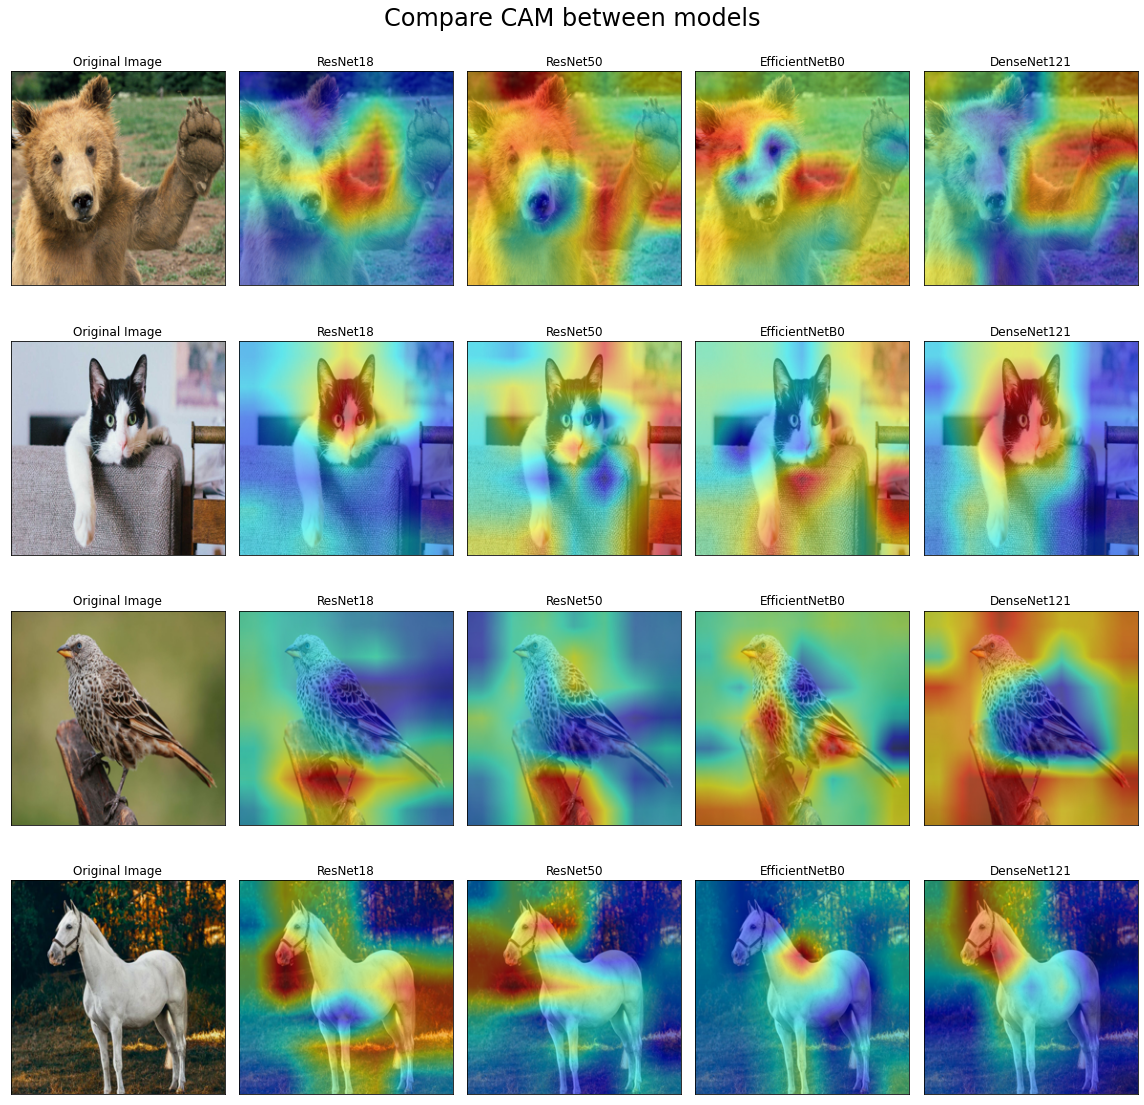

In [ ]:
compare_CAM(paths)

## 3. CAM, Grad-CAM and Score-CAM

### 3.1 Grad-CAM
Grad-CAM (Gradient-weighted Class Activation Mapping) is a method for visualizing which regions in an image are important for a specific class prediction made by a Convolutional Neural Network (CNN).

Grad-CAM works by computing **the gradients** of the target class with respect to the feature maps in the last convolutional layer of the CNN. These gradients are then used to generate a heatmap, which shows which regions in the input image contribute the most to the prediction of the target class.

### 3.2 Score-CAM
Score-CAM is a variant of Grad-CAM (Gradient-weighted Class Activation Mapping) that uses class scores (logits) instead of gradients to generate attention maps.

In Score-CAM, **the class scores** are used to weight the feature maps in the last convolutional layer of a CNN. The weighted feature maps are then averaged and upsampled to the size of the input image to generate the Score-CAM attention map.

### 3.3 Comparision CAM, Grad-CAM, and Score-CAM

The difference between CAM, Grad-CAM and Score-CAM is in how the feature maps at the last convolution layer are weighted to make the final heatmap.

| Method | Weighted method |
|--------|----------------|
| CAM    | Using weights taken out of the last fully-connected layer of the network |
| Grad-CAM | Using gradients of target class with respect to feature maps |
| Score-CAM | Using class scores (logits) |


### 3.4 Visualization

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=1a5ba9028bd54515b059aab68892c4720d7f9bc1c6aacce2bfe0fb31b2baba6c
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image


We’ll use resnet50 with pretrained weights of imagenet for finding the class activations.

In resnet50 we have used the layer4 for fetching the gradients for finding cam. In cnn higher layers will find more meaningful features, hence we are using layer4, you can also thinker with other layers to have some understanding on features extraction of models.

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def get_grad_cam(model, input_tensor):

    probs = model(input_tensor)
    class_idx = torch.argmax(probs).cpu().detach().numpy()
    
    targets = [ClassifierOutputTarget(class_idx)]
    target_layers = [model.layer4[-1]]
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam , cam_image))

    return np.uint8(255*img), cam , cam_image

def get_score_cam(model, input_tensor):

    probs = model(input_tensor)
    class_idx = torch.argmax(probs).cpu().detach().numpy()
    
    targets = [ClassifierOutputTarget(class_idx)]
    target_layers = [model.layer4[-1]]
    with ScoreCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam , cam_image))

    return np.uint8(255*img), cam , cam_image

In [ ]:
CAMs = {'CAM': [],
        'Grad-CAM': [], 
        'Score-CAM': []}

In [ ]:
for path in paths:
  print(path)
  img = np.array(Image.open(path))
  img = cv2.resize(img, (224, 224))
  img = np.float32(img) / 255
  input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  input_tensor = input_tensor.to(device)


  # load CAM images of previous examples
  CAMs['CAM'].append(CAM_images['ResNet50'][path])

  # Grad-CAM
  original, gray, overlay = get_grad_cam(model, input_tensor)
  CAMs['Grad-CAM'].append(overlay)

  # Score-CAM
  original, gray, overlay = get_score_cam(model, input_tensor)
  CAMs['Score-CAM'].append(overlay)



bear.jpg


100%|██████████| 128/128 [00:06<00:00, 20.55it/s]


cat.jpg


100%|██████████| 128/128 [00:05<00:00, 21.63it/s]


bird.jpg


100%|██████████| 128/128 [00:05<00:00, 21.63it/s]


horse.jpg


100%|██████████| 128/128 [00:05<00:00, 21.51it/s]


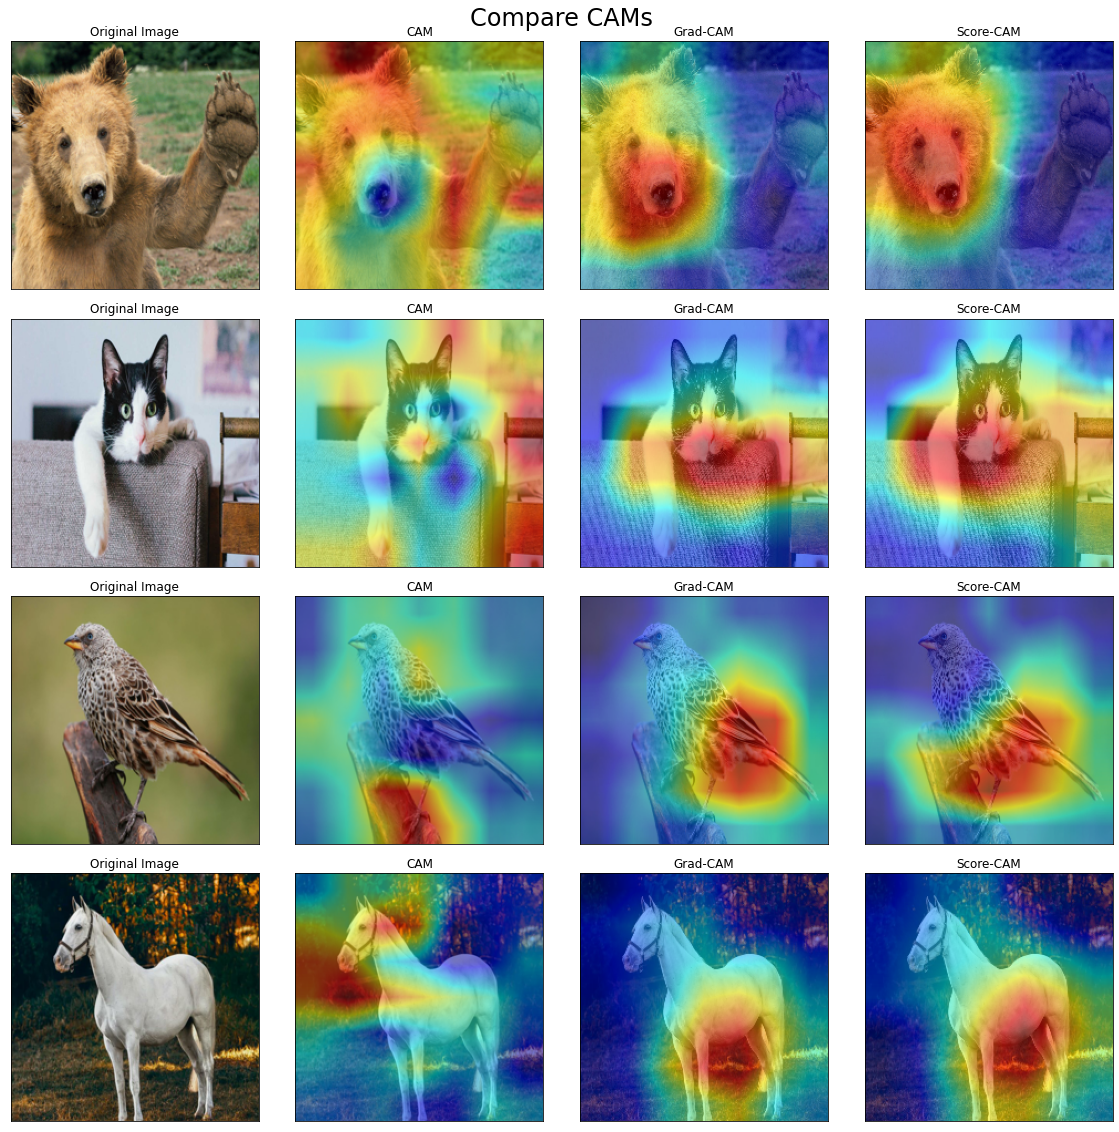

In [ ]:
rows = 4
cols = 4

fig, ax = plt.subplots(rows, cols, figsize=(16, 16))
fig.suptitle('Compare CAMs', fontsize=24)

for row, path in enumerate(paths):
  img = Image.open(path)
  img = img.resize((SIZE, SIZE))
  col = 0

  i, j = row, col
  ax[i][j].set_xticks([])
  ax[i][j].set_yticks([])
  ax[i][j].set_title('Original Image')
  ax[i][j].imshow(img)

  for name in CAMs:
    col += 1
    i, j = row, col
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].set_title(name)
    ax[i][j].imshow(CAMs[name][i])

plt.tight_layout()  
plt.subplots_adjust(top=0.95)